# 參數設定(VMD + 未使用訊號分解)

In [1]:
import os

labels = ['GroupCount']
model_type = 1 # 使用模型
predicteds = [1] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1
vmd_k = 8 # VMD分解層數
std_num = 1 # 標準差倍數
sigma = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例
  
model_dir = 'VMD_NoDecomp/_Model'

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.x_scaler.pkl
y_scaler_file_name: VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.y_scaler.pkl
model_file_name: VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.model.keras
result_file_name: VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.result.json
檔案 VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.x_scaler.pkl 存在，已刪除
檔案 VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.y_scaler.pkl 存在，已刪除
檔案 VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.model.keras 存在，已刪除
檔案 VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.result.json 存在，已刪除


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[1],133985276,9489146,1284508,9923,0,0,8410,1513,0,0,0,0,0,9923
1,2023-04-03,[1],173845707,12345851,1795732,13065,0,0,11090,1975,0,0,0,0,0,13065
2,2023-04-04,[1],179977352,13984392,1640886,14207,0,0,11796,2411,0,0,0,0,0,14207
3,2023-04-05,[1],163981342,15044918,1672361,15636,0,0,13201,2435,0,0,0,0,0,15636
4,2023-04-06,[1],386294578,38072811,4094537,38862,0,0,32274,6587,0,1,0,0,0,38862


# VMD 訊號分解

In [5]:
data_source = df_source[labels].values
u = lstm.vmd_decomposition(data_source, K = vmd_k)

print(data_source.shape)
print(u.shape)  

(395, 1)
(8, 394)


# 繪製 VMD 訊號分解圖

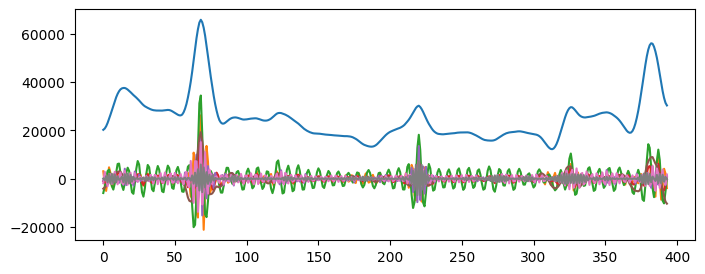

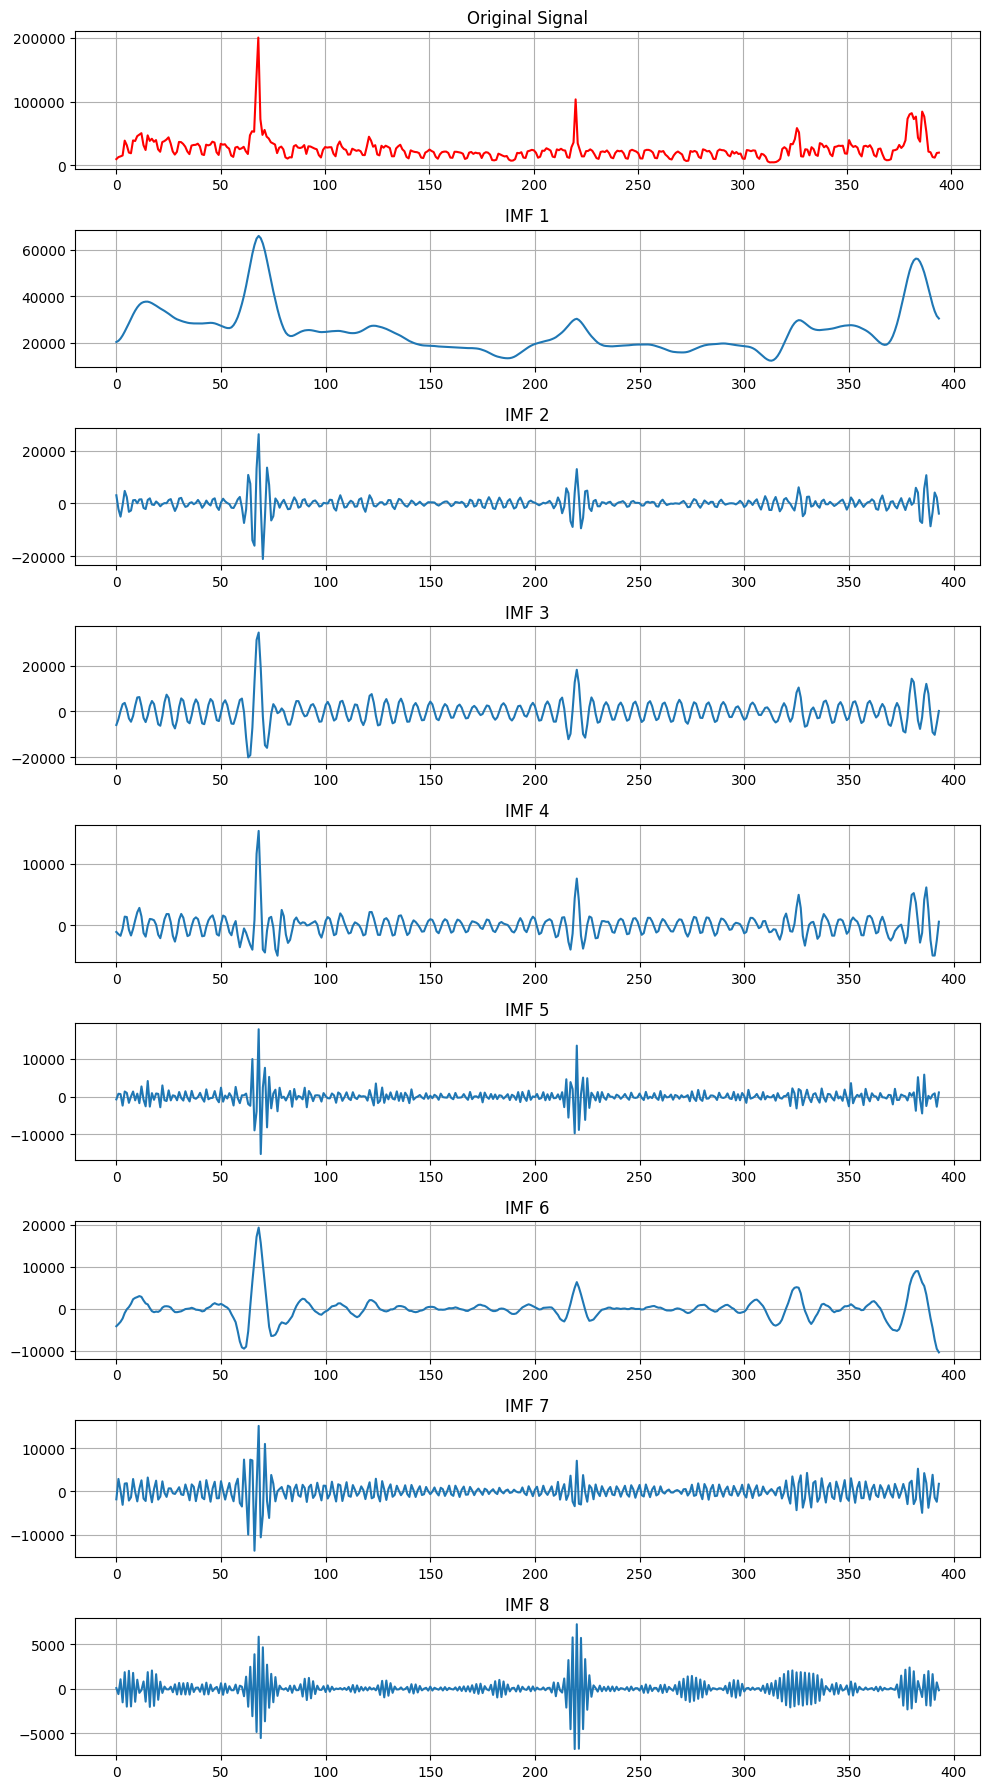

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(u.T)  
plt.show()

lstm.plot_imfs_with_original(data_source, u) 

# VMD 異常資料前處理

IMFs 的數量: 8, 每個 IMF 的長度: 394
將異常部分的值進行平滑處理，imf 1 有 68 個異常點
將異常部分的值進行平滑處理，imf 2 有 41 個異常點
將異常部分的值進行平滑處理，imf 3 有 69 個異常點
將異常部分的值進行平滑處理，imf 4 有 59 個異常點
將異常部分的值進行平滑處理，imf 5 有 51 個異常點
將異常部分的值進行平滑處理，imf 6 有 66 個異常點
將異常部分的值進行平滑處理，imf 7 有 72 個異常點
將異常部分的值進行平滑處理，imf 8 有 75 個異常點
(394,)
(394,)
(394,)
MAE: 2157.1892
MAPE: 0.0733


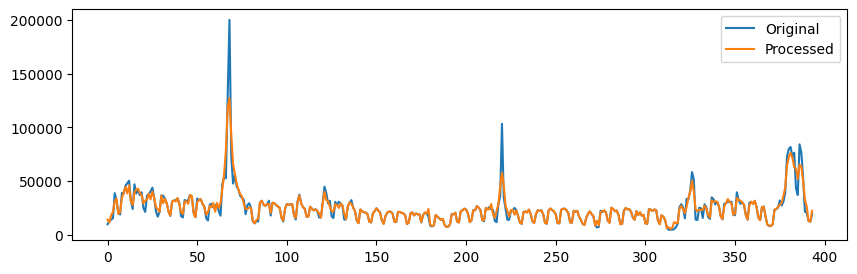

In [7]:
processed_signal = lstm.preprocess_smooth_signal_imfs(u, sigma=sigma, std_threshold=std_num)
original_signal = np.sum(u, axis=0)
# VMD 分解後會少最後一個值，因此要把原始資料的最後一個值去掉
original_data = data_source[:-1].reshape(-1)

print(original_data.shape)
print(processed_signal.shape) 
print(original_signal.shape)

mae = mean_absolute_error(original_data, processed_signal)
mape = mean_absolute_percentage_error(original_signal, processed_signal)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')

plt.figure(figsize=(10, 3))
plt.plot(data_source[:-1], label='Original') 
plt.plot(processed_signal, label='Processed')
plt.legend()
plt.show() 

# 最小最大正規化

In [8]:
x_norm, y_norm, x_scaler, y_scaler = \
    lstm.normalize_by_decomposition(processed_signal, x_scaler = None, y_scaler = None);

joblib.dump(x_scaler, x_scaler_file_name)
joblib.dump(y_scaler, y_scaler_file_name)
print('儲存最小最大縮放參數')

# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數


# 切割訓練、驗證和測試資料集

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = \
    lstm.train_val_test_split(
        x_norm,
        train_split_rate = train_split_rate,
        val_split_rate = val_split_rate
    )

# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)


# 將資料轉成 LSTM 模型所需資料格式(三維)

In [10]:
# 訓練集
x_lstm_train, y_lstm_train, _ = \
    lstm.reshape_data_for_lstm(
        x_train, y_train,
        date_array = None,
        past_day = past_day,
        future_day = future_day
    )
print('====== Train DataSet ======')
print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

# 驗證集
x_lstm_val, y_lstm_val, _ = \
    lstm.reshape_data_for_lstm(
        x_val, y_val,
        date_array = None,
        past_day = past_day,
        future_day = future_day
    )
print('====== Val DataSet ======')
print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

# 測試集
x_lstm_test, y_lstm_test, _ = \
    lstm.reshape_data_for_lstm(
        x_test, y_test,
        date_array = None,
        past_day = past_day,
        future_day = future_day
    )
print('====== Test DataSet ======')
print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)

# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)


# 定義 Model

In [11]:
# 定義 Model
model = lstm.build_model(
    model_type = model_type,
    time_step = past_day,
    n_predictions = future_day
)

# 定義 Model：1
LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        15,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [12]:
train_history = lstm.model_fit(
    model = model,
    batch_size = batch_size,
    x_train = x_lstm_train,
    y_train = y_lstm_train,
    x_val = x_lstm_val,
    y_val = y_lstm_val,
)

# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [13]:
model.save(model_file_name)
print(f'儲存模型到 {model_file_name}')

儲存模型到 VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.model.keras


# 預測

In [14]:
predict_train = lstm.predict(model, x_lstm_train)
print(f'預測 train.shape : {predict_train.shape}')

predict_val = lstm.predict(model, x_lstm_val)
print(f'預測 val.shape : {predict_val.shape}')

predict_test = lstm.predict(model, x_lstm_test)
print(f'預測 test.shape : {predict_test.shape}')

# 預測
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [15]:
# 訓練
predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
    lstm.denormalize_and_reshape_back(
        y_predict = predict_train,
        y_lstm_actual = y_lstm_train,
        y_scaler = y_scaler,
        n_predictions = future_day
    )

# 驗證
predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
    lstm.denormalize_and_reshape_back(
        y_predict = predict_val,
        y_lstm_actual = y_lstm_val,
        y_scaler = y_scaler,
        n_predictions = future_day
    )

# 測試
predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
    lstm.denormalize_and_reshape_back(
        y_predict = predict_test,
        y_lstm_actual = y_lstm_test,
        y_scaler = y_scaler,
        n_predictions = future_day
    )

# 回復預測資料值為原始數據的規模
# 回復預測資料值為原始數據的規模
# 回復預測資料值為原始數據的規模


# 查看訓練 & 驗證 & 測試集評估數據

In [16]:
# 查看訓練 & 驗證 & 測試集評估數據
print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31mTrain Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
lstm.evaluation(model, x_lstm_train, y_lstm_train)
print('--- 訓練值比較 --- ')
lstm.score(actual_train, predict_train)
print('--- 原始值比較 --- ')
mae_train, mape_train = lstm.score(actual_inverse_train, predict_inverse_train)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31mVal Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
lstm.evaluation(model, x_lstm_val, y_lstm_val)
print('--- 正規化比較 --- ')
lstm.score(actual_val, predict_val)
print('--- 原始值比較 --- ')
mae_val, mape_val = lstm.score(actual_inverse_val, predict_inverse_val)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31mTest Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
evaluations = lstm.evaluation(model, x_lstm_test, y_lstm_test)
print('--- 正規化比較 --- ')
lstm.score(actual_test, predict_test)
print('--- 原始值比較 --- ')
mae_test, mape_test = lstm.score(actual_inverse_test, predict_inverse_test)
print('')

# 查看訓練 & 驗證 & 測試集評估數據
------------------------------------------------------------------------
Train Evaluate
------------------------------------------------------------------------
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_absolute_percentage_error: 19.6761

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055 - mean_absolute_percentage_error: 17350.1309


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.03947，MAPE:428963298017.7056，MSE:0.00407，RMSE:0.06378，R square:0.65105
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:4806.86783，MAPE:0.22965，MSE:60340292.08903，RMSE:7767.9014，R square:0.65105

------------------------------------------------------------------------
Val Evaluate
------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_absolute_percentage_error: 31.3044

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_absolute_percentage_error: 31.3044


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.04553，MAPE:0.31304，MSE:0.00387，RMSE:0.06225，R square:-0.67487
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:5544.58541，MAPE:0.23019，MSE:57466040.07139，RMSE:7580.63586，R square:-0.67487

------------------------------------------------------------------------
Test Evaluate
------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106 - mean_absolute_percentage_error: 58.4308

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mean_absolute_percentage_error: 58.4308


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.08807，MAPE:0.58431，MSE:0.01063，RMSE:0.10308，R square:0.68108
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:10725.27159，MAPE:0.35984，MSE:157586053.91115，RMSE:12553.3284，R square:0.68108



# 顯示原始數據圖表

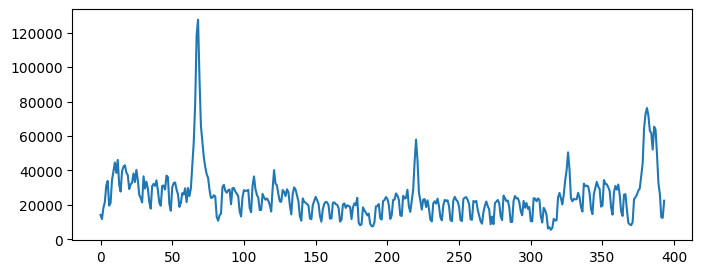

In [17]:
plt.figure(figsize=(8, 3))
plt.plot(processed_signal)
plt.show()

## 載入原始數據切割成 LSTM 格式的區段

In [18]:
# 這邊只是為了驗證數據的正確性
x_train_origin, y_train_origin, x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(
        processed_signal,
        train_split_rate = train_split_rate,
        val_split_rate = val_split_rate
    )

# 切割訓練、驗證和測試資料集
x_train.shape: (315,)
y_train.shape: (315,)
x_val.shape: (39,)
y_val.shape: (39,)
x_test.shape: (40,)
y_test.shape: (40,)


## 訓練集

原始資料 (315,)
[6398.62766716 7118.54311036 5621.73094697]
還原原始資料 (300, 1)
[[7118.54311036]
 [5621.73094697]]


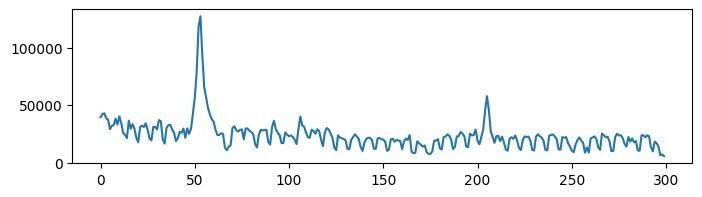

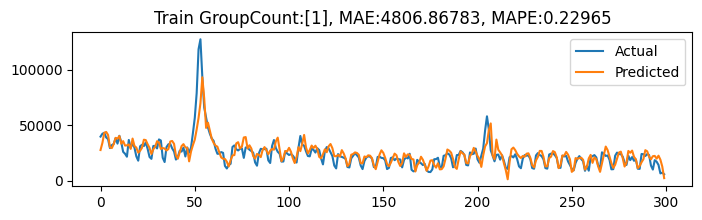

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = actual_inverse_train,
    predict = predict_inverse_train,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39,)
[34465.57966329 32294.49042661 32045.03768876]
還原原始資料 (24, 1)
[[32294.49042661]
 [32045.03768876]]


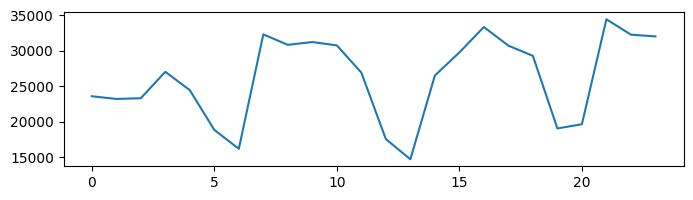

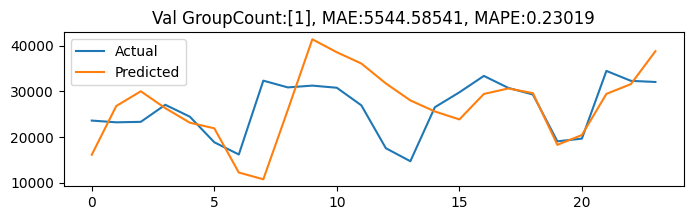

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = actual_inverse_val,
    predict = predict_inverse_val,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40,)
[12852.09183176 12524.26280988 22499.43748798]
還原原始資料 (25, 1)
[[12524.26280988]
 [22499.43748798]]
Test GroupCount:[1], BatchSize:14, MAE:10725.27159, MAPE:0.35984


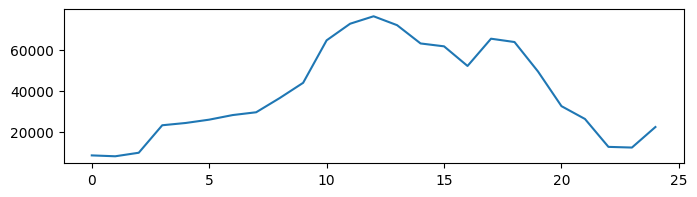

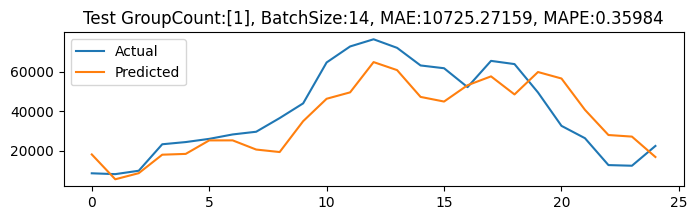

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:])

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'

print(title)
lstm.show_predict_chart(
    actual = actual_inverse_test,
    predict = predict_inverse_test,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    kfold = None
)

{'type': 'VMD_NoDecomp', 'labels': ['GroupCount'], 'model_type': 1, 'predicteds': [1], 'batch_size': 14, 'train_mae': 4806.86783, 'train_mape': 0.22965, 'test_mae': 10725.27159, 'test_mape': 0.35984, 'kfold': None, 'imfs': None}


儲存評估結果到 VMD_NoDecomp/_Model/GroupCount_mt1_data1_batch14.result.json
